In [79]:
!pip install pandas numpy scikit-learn tensorflow keras matplotlib seaborn
!pip install --upgrade jax jaxlib


In [80]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from sklearn.preprocessing import LabelEncoder

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [81]:
import gdown

file_id = "1s_7rn9zTOf0rhJB_UcDE49vQkGuFM1So"
url = f"https://drive.google.com/uc?id={file_id}"
output = "FakeNewsDataset.csv"

gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1s_7rn9zTOf0rhJB_UcDE49vQkGuFM1So
To: /content/FakeNewsDataset.csv
100%|██████████| 12.6M/12.6M [00:00<00:00, 139MB/s]


'FakeNewsDataset.csv'

In [83]:
df = df.dropna(subset=["Body"])

<ipython-input-84-7dc578d6b155>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Label"], palette='Set2')


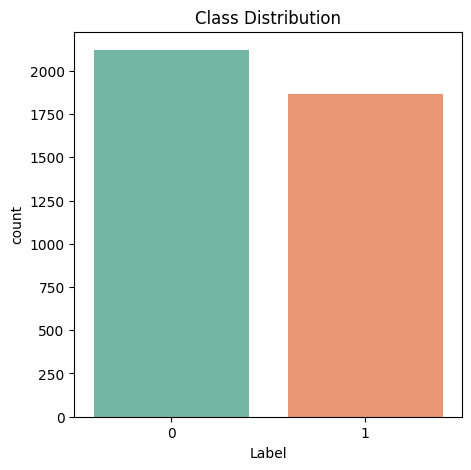

In [84]:
plt.figure(figsize=(5,5))
sns.countplot(x=df["Label"], palette='Set2')
plt.title("Class Distribution")
plt.show()

In [85]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    words = word_tokenize(text)
    stop_words = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df["Cleaned_Text"] = df["Body"].apply(clean_text)

In [87]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df["Cleaned_Text"]).toarray()

In [88]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df["Label"])

In [89]:
X_train_tfidf, X_test_tfidf, Y_train, Y_test = tts(X_tfidf, y_encoded, test_size=0.3, random_state=0)

In [95]:
nb = MultinomialNB()
nb.fit(X_train_tfidf, Y_train)
nb_preds = nb.predict(X_test_tfidf)
nb_accuracy = accuracy_score(Y_test, nb_preds)
print(f"Naïve Bayes Accuracy: {nb_accuracy*100:.4f}")

Naïve Bayes Accuracy: 92.9825


In [96]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df["Cleaned_Text"])
X_sequences = tokenizer.texts_to_sequences(df["Cleaned_Text"])
maxlen = 250  # Define max sequence length
X_padded = pad_sequences(X_sequences, maxlen=maxlen)

In [97]:
X_train, X_test, Y_train, Y_test = tts(X_padded, y_encoded, test_size=0.3, random_state=0)

In [98]:
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=maxlen),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [101]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 250, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 250, 64)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 701,857 (2.68 MB)

 Trainable params: 701,857 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
history = model.fit(X_train, Y_train, epochs=5, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 385ms/step - accuracy: 0.8247 - loss: 0.4402 - val_accuracy: 0.9716 - val_loss: 0.0941
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 321ms/step - accuracy: 0.9918 - loss: 0.0444 - val_accuracy: 0.9816 - val_loss: 0.0780
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 321ms/step - accuracy: 0.9988 - loss: 0.0109 - val_accuracy: 0.9816 - val_loss: 0.0787
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 333ms/step - accuracy: 0.9979 - loss: 0.0127 - val_accuracy: 0.9816 - val_loss: 0.0911
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 41s 338ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9825 - val_loss: 0.1048


In [102]:
lstm_preds = (model.predict(X_test) > 0.5).astype(int)
lstm_accuracy = accuracy_score(Y_test, lstm_preds)
print(f"LSTM Accuracy: {lstm_accuracy*100:.4f}")

38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step
LSTM Accuracy: 98.2456


In [103]:
nb_train_probs = nb.predict_proba(X_train_tfidf)[:, 1]
lstm_train_probs = model.predict(X_train).flatten()


88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step


In [104]:
X_meta_train = np.column_stack((nb_train_probs, lstm_train_probs))

In [105]:
nb_test_probs = nb.predict_proba(X_test_tfidf)[:, 1]
lstm_test_probs = model.predict(X_test).flatten()


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step


In [106]:
X_meta_test = np.column_stack((nb_test_probs, lstm_test_probs))


In [107]:
from sklearn.linear_model import LogisticRegression
meta_model = LogisticRegression()
meta_model.fit(X_meta_train, Y_train)


LogisticRegression()

In [108]:
y_meta_pred = meta_model.predict(X_meta_test)

In [109]:
from sklearn.metrics import accuracy_score, classification_report
print("Stacked Model Accuracy:", accuracy_score(Y_test, y_meta_pred)*100)
print(classification_report(Y_test, y_meta_pred))

Stacked Model Accuracy: 98.24561403508771
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       643
           1       0.97      1.00      0.98       554

    accuracy                           0.98      1197
   macro avg       0.98      0.98      0.98      1197
weighted avg       0.98      0.98      0.98      1197



In [110]:
def prediction_input_processing(news):
    cleaned_news = clean_text(news)

    nb_features = vectorizer.transform([cleaned_news]).toarray()
    nb_prob = nb.predict_proba(nb_features)[:, 1][0]

    seq = tokenizer.texts_to_sequences([cleaned_news])
    padded_seq = pad_sequences(seq, maxlen=maxlen)
    lstm_prob = model.predict(padded_seq).flatten()[0]

    meta_features = np.array([[nb_prob, lstm_prob]])

    meta_pred = meta_model.predict(meta_features)[0]

    if meta_pred == 1:
        return "No, It is not fake"
    else:
        return "Yes, It is fake"


In [111]:
news = "Economists Predict Steady Growth for the Global Economy in the Next Quarter"
print(prediction_input_processing(news))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
No, It is not fake


In [112]:
news = "Indian Government Announces New Infrastructure Plan to Boost National Economy"
print(prediction_input_processing(news))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
No, It is not fake


In [113]:
news = "Breaking: New study reveals that the Earth is and has always been flat and NASA and ISRO have been lying about space for decades!"
print(prediction_input_processing(news))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Yes, It is fake


In [114]:
news = "Scientists Reveal: Gravity Is Just a Simulation Designed by Elon Musk!"
print(prediction_input_processing(news))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
Yes, It is fake


In [115]:
news = "Breaking: Indian Ocean is in Antartica"
print(prediction_input_processing(news))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Yes, It is fake
